In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

# Data preparation

In [2]:
df = pd.read_csv('air_dataset.csv')
df.drop(columns='Unnamed: 0',inplace=True)
class_name = 'weekend'

In [3]:
df.head()

,CO(GT),C6H6(GT),NOx(GT),PT08.S3(NOx),NO2(GT),T,RH,weekend,PT08_feat
0,1.5,11.3,180.0,831.0,111.0,27.4,31.5,0,1186.50
1,2.0,13.0,310.0,971.0,129.0,35.0,17.3,0,1148.75
2,1.4,7.5,180.0,1114.0,119.0,24.9,28.3,0,1024.50
3,1.2,7.4,141.0,1088.0,98.0,23.2,30.5,0,1015.00
4,0.6,3.8,105.0,1254.0,89.0,22.3,33.6,0,883.25


In [4]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1, join_axes=[dfX.index])
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [5]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [33]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.


,CO(GT),C6H6(GT),NOx(GT),PT08.S3(NOx),NO2(GT),T,RH,PT08_feat,weekend
0,1.5,11.3,180.0,831.0,111.0,27.4,31.5,1186.50,0
1,2.0,13.0,310.0,971.0,129.0,35.0,17.3,1148.75,0
2,1.4,7.5,180.0,1114.0,119.0,24.9,28.3,1024.50,0
3,1.2,7.4,141.0,1088.0,98.0,23.2,30.5,1015.00,0
4,0.6,3.8,105.0,1254.0,89.0,22.3,33.6,883.25,0


# Data partitioning

In [34]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score, recall_score, precision_score

In [35]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)

# Random forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
import pickle
pickle.dump(clf, 'filename.pickle')
clf = pickle.load('filename.pickle')

TypeError: file must have a 'write' attribute

In [38]:
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7756410256410257
F1-score [0.85487215 0.50588235]
              precision    recall  f1-score   support

           0       0.79      0.93      0.85      1334
           1       0.69      0.40      0.51       538

    accuracy                           0.78      1872
   macro avg       0.74      0.66      0.68      1872
weighted avg       0.76      0.78      0.75      1872



In [39]:
classification_report(y_test, y_pred, output_dict=True)

{'0': {'precision': 0.7929487179487179,
  'recall': 0.9272863568215892,
  'f1-score': 0.8548721492743607,
  'support': 1334},
 '1': {'precision': 0.6891025641025641,
  'recall': 0.3996282527881041,
  'f1-score': 0.5058823529411764,
  'support': 538},
 'accuracy': 0.7756410256410257,
 'macro avg': {'precision': 0.7410256410256411,
  'recall': 0.6634573048048467,
  'f1-score': 0.6803772511077686,
  'support': 1872},
 'weighted avg': {'precision': 0.7631040433925049,
  'recall': 0.7756410256410257,
  'f1-score': 0.7545748680632213,
  'support': 1872}}

In [40]:
import json
json.dumps(classification_report(y_test, y_pred, output_dict=True))

'{"0": {"precision": 0.7929487179487179, "recall": 0.9272863568215892, "f1-score": 0.8548721492743607, "support": 1334}, "1": {"precision": 0.6891025641025641, "recall": 0.3996282527881041, "f1-score": 0.5058823529411764, "support": 538}, "accuracy": 0.7756410256410257, "macro avg": {"precision": 0.7410256410256411, "recall": 0.6634573048048467, "f1-score": 0.6803772511077686, "support": 1872}, "weighted avg": {"precision": 0.7631040433925049, "recall": 0.7756410256410257, "f1-score": 0.7545748680632213, "support": 1872}}'

In [41]:
json.loads(json.dumps(classification_report(y_test, y_pred, output_dict=True)))

{'0': {'precision': 0.7929487179487179,
  'recall': 0.9272863568215892,
  'f1-score': 0.8548721492743607,
  'support': 1334},
 '1': {'precision': 0.6891025641025641,
  'recall': 0.3996282527881041,
  'f1-score': 0.5058823529411764,
  'support': 538},
 'accuracy': 0.7756410256410257,
 'macro avg': {'precision': 0.7410256410256411,
  'recall': 0.6634573048048467,
  'f1-score': 0.6803772511077686,
  'support': 1872},
 'weighted avg': {'precision': 0.7631040433925049,
  'recall': 0.7756410256410257,
  'f1-score': 0.7545748680632213,
  'support': 1872}}

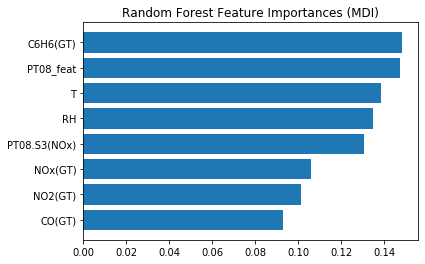

In [44]:
nbr_features = 15

tree_feature_importances = clf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[-nbr_features:]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
plt.barh(y_ticks, tree_feature_importances[sorted_idx])
plt.yticks(y_ticks, np.array(feature_names)[sorted_idx])
plt.title("Random Forest Feature Importances (MDI)")
plt.show()

In [20]:
from sklearn.inspection import permutation_importance

In [21]:
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

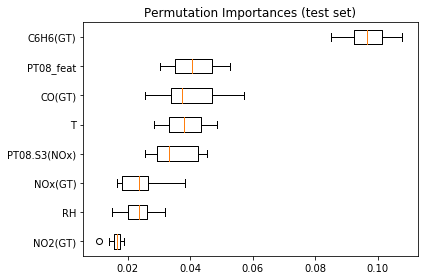

In [45]:
sorted_idx = result.importances_mean.argsort()[-nbr_features:]

fig, ax = plt.subplots()
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(feature_names)[sorted_idx])
plt.title("Permutation Importances (test set)")
plt.tight_layout()
plt.show()

In [24]:
import pydotplus
from sklearn import tree
from IPython.display import Image

In [49]:
dot_data = tree.export_graphviz(clf.estimators_[0], out_file=None,  
                                feature_names=feature_names, 
                                class_names=['stay', 'churn'],  
                                filled=True, rounded=True,  
                                special_characters=True, max_depth=4)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

InvocationException: GraphViz's executables not found

In [50]:
dot_data = tree.export_graphviz(clf.estimators_[1], out_file=None,  
                                feature_names=feature_names, 
                                class_names=['stay', 'churn'],  
                                filled=True, rounded=True,  
                                special_characters=True, max_depth=4)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

InvocationException: GraphViz's executables not found

In [51]:
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=4, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7825854700854701
F1-score [0.85754288 0.54114994]
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1334
           1       0.69      0.45      0.54       538

    accuracy                           0.78      1872
   macro avg       0.75      0.68      0.70      1872
weighted avg       0.77      0.78      0.77      1872



In [52]:
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='log2', random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.780982905982906
F1-score [0.85674354 0.53514739]
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1334
           1       0.69      0.44      0.54       538

    accuracy                           0.78      1872
   macro avg       0.74      0.68      0.70      1872
weighted avg       0.77      0.78      0.76      1872



In [53]:
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=4, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='log2', random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.718482905982906
F1-score [0.83505477 0.04007286]
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1334
           1       1.00      0.02      0.04       538

    accuracy                           0.72      1872
   macro avg       0.86      0.51      0.44      1872
weighted avg       0.80      0.72      0.61      1872



### Cross Validation

In [54]:
from sklearn.model_selection import cross_val_score

In [55]:
clf = RandomForestClassifier()
scores = cross_val_score(clf, X, y, cv=5)

print('Accuracy %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Accuracy 0.708 +/- 0.023


### Tuning the hyper-parameters

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [57]:
param_list = {'min_samples_split': [2, 5, 10, 20],
              'min_samples_leaf': [1, 5, 10, 20],
             }

grid_search = GridSearchCV(clf, param_grid=param_list, cv=5)
grid_search.fit(X_train, y_train)
clf = grid_search.best_estimator_

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7847222222222222
F1-score [0.86021505 0.53193961]
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      1334
           1       0.71      0.43      0.53       538

    accuracy                           0.78      1872
   macro avg       0.75      0.68      0.70      1872
weighted avg       0.77      0.78      0.77      1872



In [58]:
param_list = {'max_depth': [None] + list(np.arange(2, 20)),
              'min_samples_split': [2, 5, 10, 20, 30, 50, 100],
              'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100],
             }

random_search = RandomizedSearchCV(clf, param_distributions=param_list, n_iter=20, cv=5)
random_search.fit(X_train, y_train)
clf = random_search.best_estimator_


y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7654914529914529
F1-score [0.85263511 0.42614379]
              precision    recall  f1-score   support

           0       0.77      0.95      0.85      1334
           1       0.72      0.30      0.43       538

    accuracy                           0.77      1872
   macro avg       0.75      0.63      0.64      1872
weighted avg       0.76      0.77      0.73      1872



In [59]:
random_search.cv_results_['params'][random_search.cv_results_['rank_test_score'][0]]

{'min_samples_split': 100, 'min_samples_leaf': 50, 'max_depth': None}

# Bagging

In [60]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

If None, then the base estimator is a decision tree.


In [61]:
clf = BaggingClassifier(base_estimator=None, n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7767094017094017
F1-score [0.85240113 0.54166667]
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      1334
           1       0.66      0.46      0.54       538

    accuracy                           0.78      1872
   macro avg       0.73      0.68      0.70      1872
weighted avg       0.76      0.78      0.76      1872



In [62]:
clf = BaggingClassifier(base_estimator=SVC(C=1000), n_estimators=10, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7702991452991453
F1-score [0.85182633 0.48931116]
              precision    recall  f1-score   support

           0       0.79      0.93      0.85      1334
           1       0.68      0.38      0.49       538

    accuracy                           0.77      1872
   macro avg       0.73      0.65      0.67      1872
weighted avg       0.76      0.77      0.75      1872



In [63]:
clf = BaggingClassifier(base_estimator=RandomForestClassifier(n_estimators=100), n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7708333333333334
F1-score [0.85413125 0.46575342]
              precision    recall  f1-score   support

           0       0.78      0.94      0.85      1334
           1       0.71      0.35      0.47       538

    accuracy                           0.77      1872
   macro avg       0.74      0.64      0.66      1872
weighted avg       0.76      0.77      0.74      1872



# Boosting

In [64]:
from sklearn.ensemble import AdaBoostClassifier

If None, then the base estimator is DecisionTreeClassifier(max_depth=1).

In [65]:
clf = AdaBoostClassifier(base_estimator=None, n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7035256410256411
F1-score [0.81689211 0.22159888]
              precision    recall  f1-score   support

           0       0.73      0.93      0.82      1334
           1       0.45      0.15      0.22       538

    accuracy                           0.70      1872
   macro avg       0.59      0.54      0.52      1872
weighted avg       0.65      0.70      0.65      1872



In [66]:
clf = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=100), n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7772435897435898
F1-score [0.855359   0.51567944]
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1334
           1       0.69      0.41      0.52       538

    accuracy                           0.78      1872
   macro avg       0.74      0.67      0.69      1872
weighted avg       0.76      0.78      0.76      1872

